In [1]:
import pandas as pd
import helper_fn as hf
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
import sklearn.feature_selection as fs
from sklearn.model_selection import train_test_split
import sklearn.metrics as sm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import mifs
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import matplotlib.patches as mpatches
from sklearn.cluster import OPTICS, cluster_optics_dbscan
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold
import os
from scipy.stats import kruskal
from tabulate import tabulate
import numpy as np
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from scipy.special import logit
import pdb
from matplotlib.lines import Line2D
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import mannwhitneyu
import scipy.stats as stats
import plotly.express as px
from scipy.stats import entropy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from statannot import add_stat_annotation
from sklearn.impute import KNNImputer
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
adni_figure_path = "/Users/raghavtandon/Documents/PhD/multi-modal/figures_publication/ADNI/"

# Read data
1. Read the Lah Data
2. read the ADNI data

## Difference in Emory and ADNI distributions

### Read Lah data

In [3]:
data_save_path = "/Users/raghavtandon/Documents/PhD/multi-modal/data"
X, X_unscaled, label_df = hf.readData()
sbj_asymad = label_df[label_df["DX"] == "AsymAD"]["sbj"]
X = X[X.index.isin(sbj_asymad)]
X_unscaled = X_unscaled[X_unscaled.index.isin(sbj_asymad)]
lah_peptides = ["LGADMEDVR", "LGADMEDVCGR", "GLQEAAEER", "YDNSLK", "AQALEQAK"]
imputer = KNNImputer(n_neighbors=15)

### Function to read the ADNI data and clean its column names

In [8]:
path="/Users/raghavtandon/Documents/PhD/multi-modal/data/ADNI/adni_followup_av45.csv"
def read_adni(path):
    df_adni = pd.read_csv(path)
    old_cols = df_adni.columns[37:].tolist()
    new_cols = [x.split(";")[-1] for x in old_cols]
    rename_dict = dict(zip(old_cols, new_cols))
    df_adni.rename(columns=rename_dict, inplace=True)
    return df_adni

In [9]:
## Print the age distributions in ADNI data
df_adni = read_adni(path)
print(df_adni.groupby("DX").median()["AGE"])

DX
AD         74.05
AsymAD     75.35
Control    70.90
Name: AGE, dtype: float64


In [10]:
df_adni = df_adni[df_adni["DX"]=="AsymAD"]
peptides = ["LGADMEDVR", "LGADMEDVCGR", "GLQEAAEER", "YDNSLK", "AQALEQAK"]
# peptides = ['VLTPTQVK','QSELSAK','QVVAGLNFR','LFEELVR','VIGSGCNLDSAR',
#             'IESQTQEEVR','LGADMEDVCGR','EAFSLFDK','AQALEQAK','GDLGIEIPAEK']
df_lah = X_unscaled[peptides]
df_adni = df_adni[peptides]
df_adni.columns.name = "Peptide"
df_lah = df_lah.melt()
df_lah["source"] = "Emory"
df_adni = df_adni.melt()
df_adni["source"] = "ADNI"
df_final = pd.concat([df_lah, df_adni], axis=0)

### Compare peptide distributions between ADNI and EHBS

In [ ]:
fig, ax = plt.subplots(1,5, figsize=(15,3), sharex=False, sharey=False)
for i in range(5):
    pep = lah_peptides[i]
    df_final_sub = df_final[df_final["Peptide"].isin([pep])]
    sns.violinplot(data=df_final_sub, ax=ax[i], x="Peptide", y="value", hue="source")
    add_stat_annotation(ax[i], data=df_final_sub, x="Peptide", y="value", hue="source", 
                        box_pairs=[((pep, "Emory"),(pep, "ADNI"))],
                    test='Mann-Whitney', text_format='star', loc='outside', verbose=0, fontsize=20)
    ax[i].legend(loc=0, fancybox=True, framealpha=0.2)
    ax[i].set_ylabel("Expression", fontsize=15); ax[i].set_xlabel(""); ax[i].set_xticklabels([pep], fontsize=15)
fig.tight_layout()
fig.savefig("/Users/raghavtandon/Documents/PhD/multi-modal/figures_publication/ADNI/distr.png")

## t-SNE (CN-like vs AD_like AsymAD)

In [11]:
ss = StandardScaler()
df_adni = read_adni(path)
df_adni = df_adni[df_adni["DX"]=="AsymAD"]
progression_col = "fdg_progression"
df_adni = df_adni[df_adni[progression_col].isin(["YES", "NO"])]

y_adni = df_adni[progression_col].map({"YES":1, "NO":0})
# peptides = ["LGADMEDVR", "LGADMEDVCGR", "GLQEAAEER", "YDNSLK", "AQALEQAK"]
df_lah = X_unscaled[peptides]
df_adni = df_adni[peptides]
df_adni_imputed = imputer.fit_transform(df_adni)
df_adni = pd.DataFrame(df_adni_imputed, index=df_adni.index, columns=df_adni.columns)
df_adni_scaled = ss.fit_transform(df_adni)

In [12]:
df_lah_master = pd.read_csv("/Users/raghavtandon/Documents/PhD/multi-modal/data/final_viz_dataframe.csv", index_col='sbj')
y_lah = df_lah_master["predicted_final"]
y_lah = y_lah[y_lah.isin(["Control-like ASYMAD", "AD-like ASYMAD"])]
y_lah = y_lah.map({"AD-like ASYMAD":1, "Control-like ASYMAD":0})
df_lah["y"] = y_lah
y_lah = df_lah["y"]
del df_lah["y"]

/Users/raghavtandon/opt/miniconda3/envs/omics/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Plot the t-SNE for CN-like vs AD-like in ADNI

KL distance - 0.2425534427165985


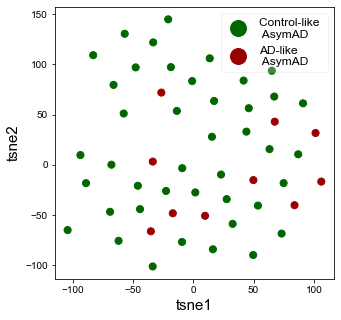

In [21]:
# df = df_adni
df = df_adni_scaled
fig, ax = plt.subplots(1,1, figsize=(5,5))
random_state=1
tsne = TSNE(n_components=2, random_state=random_state)

tsne_scores = tsne.fit_transform(df)
print("KL distance - {}".format(tsne.kl_divergence_))
ax.scatter(tsne_scores[:,0], tsne_scores[:,1], c=y_adni.replace({0: "#006600", 1: "#990000"}), s=50)
ax.set_xlabel("tsne1", fontsize=15); ax.set_ylabel("tsne2", fontsize=15)
classes10 = ["Control", "AD"]
classes11 = ["Control-like \n AsymAD", "AD-like \n AsymAD"]
lb2 = {'Control': "#006600", 'AD': "#990000"}
recs11 = hf.add_legend(classes11, [lb2[i] for i in classes10[:2]])
legend_properties = {'size':12, 'family':'Arial'}
ax.legend(recs11, [i for i in classes11], fontsize=12,
                 prop=legend_properties,
				framealpha=0.25,
				loc=0)
fig.savefig("/Users/raghavtandon/Documents/PhD/multi-modal/figures_publication/ADNI/jmi_peptides_adni_tsne.png")

## t-SNE (Control vs AD)

In [ ]:
df_adni = read_adni(path)
df_adni = df_adni[df_adni["DX"].isin(["Control", "AD"])]
y_adni = df_adni["DX"].map({"Control":0, "AD":1})
peptides = ["ADQDTIR", "AQALEQAK", "ELQAAQAR", "EPVAGDAVPGPK", "IASNTQSR", "LGADMEDVCGR", "VVSSIEQK", "YDNSLK"]
df_adni = df_adni[peptides]
df_adni_imputed = imputer.fit_transform(df_adni)
df_adni = pd.DataFrame(df_adni_imputed, index=df_adni.index, columns=df_adni.columns)
df_adni["y"] = y_adni
y_adni = df_adni["y"]
del df_adni["y"]
df_adni_scaled = ss.fit_transform(df_adni)

In [ ]:
# df = df_adni
df = df_adni_scaled
fig, ax = plt.subplots(1,1, figsize=(5,5))
random_state=0
tsne = TSNE(n_components=2, random_state=random_state)

tsne_scores = tsne.fit_transform(df)
print("KL distance - {}".format(tsne.kl_divergence_))
ax.scatter(tsne_scores[:,0], tsne_scores[:,1], c=y_adni.replace({0: "#006600", 1: "#990000"}), s=50)
ax.set_xlabel("tsne1", fontsize=15); ax.set_ylabel("tsne2", fontsize=15)
classes10 = ["Control", "AD"]
classes11 = ["Control-like \n AsymAD", "AD-like \n AsymAD"]
lb2 = {'Control': "#006600", 'AD': "#990000"}
recs11 = hf.add_legend(classes11, [lb2[i] for i in classes10[:2]])
legend_properties = {'size':12, 'family':'Arial'}
ax.legend(recs11, [i for i in classes11], fontsize=12,
                 prop=legend_properties,
				framealpha=0.25,
				loc=0)

## Classification - CN/BM- vs AD

In [ ]:
df_adni = read_adni(path)
df_adni = df_adni[df_adni["DX"].isin(["Control", "AD"])]
peptides = ["ADQDTIR", "AQALEQAK", "ELQAAQAR", "EPVAGDAVPGPK", "IASNTQSR", "LGADMEDVCGR", "VVSSIEQK", "YDNSLK"]
df_adni.rename(columns={"RID":"sbj"}, inplace=True)
dx_cn_ad = df_adni[["sbj", "DX"]]
df_adni.set_index("sbj", inplace=True)
df_adni = df_adni[peptides]
df_adni_imputed = imputer.fit_transform(df_adni)
df_adni = pd.DataFrame(df_adni_imputed, index=df_adni.index, columns=df_adni.columns)
df_adni_scaled = ss.fit_transform(df_adni[peptides])
df_adni_scaled = pd.DataFrame(df_adni_scaled, columns=df_adni.columns, index=df_adni.index)

In [ ]:
hf.plotROC(df_adni_scaled, dx_cn_ad, peptides, "cn_ad", figure_save_path=adni_figure_path)

## Classification (Cn-like vs AD-like)

In [ ]:
df_adni = read_adni(path)
df_adni = df_adni[df_adni["DX"].isin(["AsymAD"])]
progression_col = "fdg_progression"
df_adni = df_adni[df_adni[progression_col].isin(["YES", "NO"])]
df_adni[progression_col] = df_adni[progression_col].map({"YES":1, "NO":0})
peptides = ["AQALEQAK", "LGADMEDVCGR", "LGADMEDVR", "GLQEAAEER", "YDNSLK"]
df_adni.rename(columns={"RID":"sbj"}, inplace=True)
dx_cn_ad = df_adni[["sbj", progression_col]]
df_adni.set_index("sbj", inplace=True)
df_adni = df_adni[peptides]
df_adni_imputed = imputer.fit_transform(df_adni)
df_adni = pd.DataFrame(df_adni_imputed, index=df_adni.index, columns=df_adni.columns)
dx_cn_ad.rename(columns={progression_col:"DX"}, inplace=True)
df_adni = df_adni[peptides]
df_adni_scaled = ss.fit_transform(df_adni)
df_adni_scaled = pd.DataFrame(df_adni_scaled, columns=df_adni.columns, index=df_adni.index)

In [ ]:
print("Count of stable and progressive AsymAD", Counter(dx_cn_ad["DX"]))

In [ ]:
hf.plotROC(df_adni_scaled, dx_cn_ad, peptides, "cn_like_ad_like", figure_save_path=adni_figure_path)

In [ ]:
a = [0.86, 0.57, 0.86, 0.50, 0.71, 1.0]
np.mean(a); stats.sem(a)

## Important note - The matched data was used from the overall AV45 file. It has the same list of AsymAD subjects (progressives and controls)

### Leave one out CV

In [ ]:
x_new = pd.merge(df_adni_scaled, dx_cn_ad, left_index=True, right_on="sbj", how="inner")
df_adni = x_new[peptides]
dx_cn_ad = x_new[["sbj", "DX"]]

In [ ]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
x_adni = df_adni.values
y_adni = dx_cn_ad["DX"].values
clf = LogisticRegression( C=1.0, random_state=0, dual=False, max_iter=3000, class_weight="balanced")
y_true=[];y_pred = [];
for i, (train_index, test_index) in enumerate(loo.split(df_adni)):
    x_train = x_adni[train_index,:]
    x_test = x_adni[test_index,:]
    y_train = y_adni[train_index]
    y_test = y_adni[test_index]
    clf.fit(x_train, y_train)
    y_predict = clf.predict(x_test)
    y_true.append(y_test)
    y_pred.append(y_predict)
    

In [ ]:
sm.f1_score(np.array(y_true), np.array(y_pred))

In [ ]:
sm.top_k_accuracy_score(np.array(y_true), np.array(y_pred))

In [ ]:
viz = sm.plot_roc_curve(clf, x_test, y_test)

In [ ]:
from sklearn.utils import shuffle
X = x_adni; y = y_adni;

In [ ]:
for _ in range(100):
    X, y = shuffle(X, y)
x_train = X[:40,:]; y_train = y[:40]; x_test = X[40:,:]; y_test = y[40:];
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
# sm.confusion_matrix(y_test, y_pred)
print(sm.f1_score(y_test, y_pred))

In [ ]:
fig, ax = plt.subplots(1,1)
mean_fpr = np.linspace(0,1,100)
interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
ax.plot(mean_fpr, interp_tpr)
viz = sm.plot_roc_curve(clf, x_test, y_test, ax=ax)

In [ ]:
viz.roc_auc

In [ ]:
viz.fpr; viz.tpr; interp_tpr

In [ ]:
interp_tpr[0] = 0

In [ ]:
interp_tpr

In [ ]:
tprs = [interp_tpr, interp_tpr]
# tprs.append(interp_tpr)

In [ ]:
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = sm.auc(mean_fpr, mean_tpr)

In [ ]:
mean_auc

## CN vs AsymAD

In [22]:
path="/Users/raghavtandon/Documents/PhD/multi-modal/data/ADNI/adni_cn_asymad_matched.csv"
def read_adni(path):
    df_adni = pd.read_csv(path)
    old_cols = df_adni.columns[37:].tolist()
    new_cols = [x.split(";")[-1] for x in old_cols]
    rename_dict = dict(zip(old_cols, new_cols))
    df_adni.rename(columns=rename_dict, inplace=True)
    return df_adni

In [23]:
df_adni = read_adni(path)
df_adni = df_adni[df_adni["DX"]=="AsymAD"]
peptides = ["LGADMEDVR", "LGADMEDVCGR", "GLQEAAEER", "YDNSLK", "AQALEQAK"]
# peptides = ['VLTPTQVK','QSELSAK','QVVAGLNFR','LFEELVR','VIGSGCNLDSAR',
#             'IESQTQEEVR','LGADMEDVCGR','EAFSLFDK','AQALEQAK','GDLGIEIPAEK']
df_lah = X_unscaled[peptides]
df_adni = df_adni[peptides]
df_adni.columns.name = "Peptide"
df_lah = df_lah.melt()
df_lah["source"] = "Emory"
df_adni = df_adni.melt()
df_adni["source"] = "ADNI"
df_final = pd.concat([df_lah, df_adni], axis=0)

In [ ]:
fig, ax = plt.subplots(2,5, figsize=(15,3), sharex=False, sharey=False)
for i in range(10):
    pep = peptides[i]
    df_final_sub = df_final[df_final["Peptide"].isin([pep])]
    sns.violinplot(data=df_final_sub, ax=ax[i//5,i%5], x="Peptide", y="value", hue="source")
    add_stat_annotation(ax[i//5,i%5], data=df_final_sub, x="Peptide", y="value", hue="source", 
                        box_pairs=[((pep, "Emory"),(pep, "ADNI"))],
                    test='Mann-Whitney', text_format='star', loc='outside', verbose=0, fontsize=20)
    ax[i//5,i%5].legend(loc=0, fancybox=True, framealpha=0.2)
    ax[i//5,i%5].set_ylabel("Expression", fontsize=15); ax[i//5,i%5].set_xlabel(""); ax[i//5,i%5].set_xticklabels([pep], fontsize=15)
fig.tight_layout()
fig.savefig("/Users/raghavtandon/Documents/PhD/multi-modal/figures_publication/ADNI/distr_cn_asymad.png")

## t-SNE (Control vs AsymAD)

In [24]:
df_adni = read_adni(path)
ss = StandardScaler()
df_adni = df_adni[df_adni["DX"].isin(["Control", "AsymAD"])]
y_adni = df_adni["DX"].map({"Control":0, "AsymAD":1})
df_adni = df_adni[peptides]
df_adni_imputed = imputer.fit_transform(df_adni)
df_adni = pd.DataFrame(df_adni_imputed, index=df_adni.index, columns=df_adni.columns)
df_adni["y"] = y_adni
y_adni = df_adni["y"]
del df_adni["y"]
df_adni_scaled = ss.fit_transform(df_adni)

KL distance - 0.18209122121334076


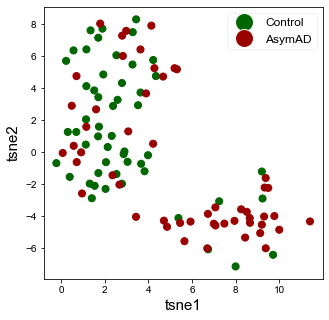

In [28]:
# df = df_adni
df = df_adni_scaled
fig, ax = plt.subplots(1,1, figsize=(5,5))
random_state=0
tsne = TSNE(n_components=2, random_state=random_state)

tsne_scores = tsne.fit_transform(df)
print("KL distance - {}".format(tsne.kl_divergence_))
ax.scatter(tsne_scores[:,0], tsne_scores[:,1], c=y_adni.replace({0: "#006600", 1: "#990000"}), s=50)
ax.set_xlabel("tsne1", fontsize=15); ax.set_ylabel("tsne2", fontsize=15)
classes10 = ["Control", "AD"]
classes11 = ["Control", "AsymAD"]
lb2 = {'Control': "#006600", 'AD': "#990000"}
recs11 = hf.add_legend(classes11, [lb2[i] for i in classes10[:2]])
legend_properties = {'size':12, 'family':'Arial'}
ax.legend(recs11, [i for i in classes11], fontsize=12,
                 prop=legend_properties,
				framealpha=0.25,
				loc=0)
fig.savefig("/Users/raghavtandon/Documents/PhD/multi-modal/figures_publication/ADNI/cn_asymad_tsne.png")

## Classification CN/BM- vs AsymAD

In [ ]:
df_adni = read_adni(path)
df_adni = df_adni[df_adni["DX"].isin(["Control", "AsymAD"])]
df_adni.rename(columns={"RID":"sbj"}, inplace=True)
dx_cn_ad = df_adni[["sbj", "DX"]]
df_adni.set_index("sbj", inplace=True)
df_adni = df_adni[peptides]
df_adni_imputed = imputer.fit_transform(df_adni)
df_adni = pd.DataFrame(df_adni_imputed, index=df_adni.index, columns=df_adni.columns)
df_adni_scaled = ss.fit_transform(df_adni[peptides])
df_adni_scaled = pd.DataFrame(df_adni_scaled, columns=df_adni.columns, index=df_adni.index)

In [ ]:
hf.plotROC(df_adni_scaled, dx_cn_ad, peptides, "cn_asymad_matched", figure_save_path=adni_figure_path)

In [ ]:
dx_cn_ad